In [1]:
# link on strategy: http://www.blackarbs.com/blog/a-dead-simple-2-asset-portfolio-that-crushes-the-sp500/4/4/2016
# Linear algebra refresher: http://www.deeplearningbook.org/
# Dependency ratio and other stats: https://eranraviv.com/correlation-and-correlation-structure-2-copulas/

# Imports & Helper Functions

In [2]:
%matplotlib inline
#import pdblp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
import seaborn as sns
from pylab import rcParams
from tqdm import tnrange, tqdm_notebook, tqdm
import time
plt.style.use('ggplot')#'fivethirtyeight')
sns.set_style('darkgrid')

import scipy.stats as stats
from scipy.optimize import minimize
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as sch
from datetime import date
from sklearn.externals import joblib

# con = pdblp.BCon(debug=False)
# con.start()

In [3]:
def to_percent(x):
    try: f_string = '{:.0%}'.format(x)
    except: f_string = x
    return f_string

def to_decimal(x):
    try:
        if x >= 100:
            f_string = '{0:,.0f}'.format(x)
        elif x >= 10:
            f_string = '{0:,.1f}'.format(x)
        else:
            f_string = '{0:,.2f}'.format(x)
            
    except: f_string = x
    return f_string

def max_drawdown(df_returns):
    max_dd = (np.cumprod(1+df_returns)/np.maximum.accumulate(np.cumprod(1+df_returns))-1).min()
    return max_dd

In [4]:
def to_summary(df_returns):
    # Daily return calcs
    df_summary = pd.DataFrame(columns=df_returns.columns)
    df_summary.loc['Summary Stats:'] = ''
    MOIC = np.prod(1+df_returns)
    CAGR = MOIC**(periodicity/len(df_returns))-1
    track_err = np.sqrt(((df_returns.subtract(df_returns.iloc[:, 0], axis=0))**2).sum(axis=0)\
                        /(len(df_returns)-1))*np.sqrt(periodicity)
    df_summary.loc['CAGR'] = CAGR.apply(to_percent)
    df_summary.loc['MOIC'] = MOIC
    df_summary.loc['Sharpe'] = CAGR/(np.std(df_returns)*np.sqrt(periodicity))
    df_summary.loc['Sortino'] = CAGR/(np.std(np.clip(df_returns, a_max=0, a_min=None))*np.sqrt(periodicity))
    df_summary.loc['Information Ratio'] = (CAGR-CAGR[0])/track_err
    df_summary.loc['Skew'] = stats.skew(df_returns, bias=True)
    #df_summary.loc['Excess Kurtosis'] = stats.kurtosis(df_returns, fisher=True)
    df_summary.loc['Max Drawdown'] = max_drawdown(df_returns).apply(to_percent)
    df_summary.loc['Ulcer Index'] = np.sqrt(np.sum((np.cumprod(1+df_returns)\
                                                    /np.maximum.accumulate(np.cumprod(1+df_returns))-1)**2)\
                                            /len(df_returns))*100
    
    df_summary.loc['Ulcer Performance Index'] = CAGR/df_summary.loc['Ulcer Index']*100
    
    cumprod = np.array(np.cumprod(1+df_returns))
    V = cumprod/cumprod[:, 0].reshape(-1, 1)
    dds = V/np.maximum.accumulate(V)-1
    df_summary.loc['V2 Ratio'] = (CAGR - CAGR[0])/np.sqrt(np.sum(dds**2, axis=0)/len(dds)) # https://en.wikipedia.org/wiki/V2_ratio

    q = 0.05
    df_summary.loc['Dependency Ratio ('+str(q)+')', :] = ((df_returns[df_returns.iloc[:, 0]<df_returns.iloc[:, 0]\
                                                                      .quantile(q=q)]\
                                                          < df_returns.quantile(q=q, axis=0)).sum()\
           /len(df_returns[df_returns.iloc[:, 0]<df_returns.iloc[:, 0].quantile(q=q)]))\
                                                                      .apply(to_percent)
    
    df_summary = df_summary.applymap(to_decimal)
    df_summary.loc['MOIC', :] = df_summary.loc['MOIC', :]+str('x')
    
    # Monthly return calcs
    df_summary.loc['Monthly Perf. Metrics:'] = ''
    df_months = pd.DataFrame(columns=df_returns.columns)
    df_returnsM = (1+df_returns).resample('M').prod()-1
    MOIC_M = np.prod(1+df_returnsM)
    CAGR_M = MOIC_M**(12/len(df_returnsM))-1
    track_err_M = np.sqrt(((df_returnsM.subtract(df_returnsM.iloc[:, 0], axis=0))**2).sum(axis=0)\
                          /(len(df_returnsM)-1))*np.sqrt(12)
    df_months.loc['Sharpe'] = CAGR_M/(np.std(df_returnsM)*np.sqrt(12))
    df_months.loc['Sortino'] = CAGR_M/(np.std(np.clip(df_returnsM, a_max=0, a_min=None))*np.sqrt(12))
    df_months.loc['Information Ratio'] = (CAGR_M-CAGR_M[0])/track_err_M
    df_months.loc['Skew'] = stats.skew(df_returnsM, bias=True)
    df_months.loc['Max Drawdown'] = max_drawdown(df_returnsM).apply(to_percent)
    df_months.loc['Ulcer Index'] = np.sqrt(np.sum((np.cumprod(1+df_returnsM)\
                                                   /np.maximum.accumulate(np.cumprod(1+df_returnsM))-1)**2)\
                                           /len(df_returnsM))*100
    
    df_months.loc['Ulcer Performance Index'] = CAGR_M/df_months.loc['Ulcer Index']*100
    
    cumprodM = np.array(np.cumprod(1+df_returnsM))
    V_M = cumprodM/cumprodM[:, 0].reshape(-1, 1)
    ddsM = V_M/np.maximum.accumulate(V_M)-1
    df_months.loc['V2 Ratio'] = (CAGR_M - CAGR_M[0])/np.sqrt(np.sum(ddsM**2, axis=0)/len(ddsM))
        
    if len(df_returnsM) >= 36: df_months.loc['Calmar'] = -(np.prod(1+df_returnsM.iloc[-12*3:])**(1/3)-1)\
                                                         / max_drawdown(df_returnsM.iloc[-12*3:])
    
    df_months.loc['Gain to Pain Ratio'] = -np.sum(df_returnsM)/np.sum(np.clip(df_returnsM, a_max=0, a_min=None))
    
    df_months.loc['Upside Beta'] = df_returnsM[df_returnsM.iloc[:, 0]>0].cov().iloc[0, :]\
                                 / df_returnsM[df_returnsM.iloc[:, 0]>0].cov().iloc[0, 0]
    
    df_months.loc['Downside Beta'] = df_returnsM[df_returnsM.iloc[:, 0]<0].cov().iloc[0, :]\
                                   / df_returnsM[df_returnsM.iloc[:, 0]<0].cov().iloc[0, 0]
    
    df_months = df_months.applymap(to_decimal)
    df_summary = df_summary.append(df_months)
    
    # Annuals
    df_summary.loc['Annual Returns:'] = ''
    df_annuals = df_returns.groupby(df_returns.index.year).apply(lambda x: np.prod(1+x)-1).applymap(to_percent)
    df_summary = df_summary.append(df_annuals)

    # Drawdowns
    df_summary.loc['Annual Max DD:'] = ''    
    df_maxdd = df_returns.groupby(df_returns.index.year).apply(max_drawdown).applymap(to_percent)
    df_summary = df_summary.append(df_maxdd)
    return df_summary

In [5]:
def numpy_ewm(data, window, method=None):
    """
    Calculates exponential weighted moving average on 2x2 numpy array.
    Choose 'halflife', 'com', or 'span' methods.
    Modified to fit 2d array from stackoverflow answer at https://stackoverflow.com/a/42926270/8678259
    """
    if method == 'halflife': alpha = 1-np.exp(np.log(0.5)/window)
    elif method == 'com': alpha = 1/(1+window)
    else: alpha = 2/(1+window)

    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0].reshape(1, -1)*pows[1:].reshape(-1, 1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr.reshape(-1, 1)
    cumsums = mult.cumsum(axis=0)
    out = offset + cumsums*scale_arr[::-1].reshape(-1, 1)
    return out

### Global Minimum Variance Portfolio

In [6]:
#-------------------------------------
# Global minimum variance portfolio
# Pages 7-8 of https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
#-------------------------------------
def min_var(returns_array, MV_lambda):
    n_ticks = returns_array.shape[1]
    A = np.zeros([n_ticks+1, n_ticks+1])
    A[:-1, :-1] = 2*np.cov(returns_array.T)
    A[-1, 0:-1] = 1
    A[0:-1, -1] = 1
    z0 = np.zeros([n_ticks+1, 1])
    z0[-1] = MV_lambda
    b = np.zeros([n_ticks+1, 1])
    b[-1] = 1
    z = np.linalg.inv(A) @ b
    return z[:-1]

MV_lambda = 0.5

### Equal Risk Contribution

In [7]:
#-------------------------------------
# Newton method ERC weight calc
# per 
# http://www.top1000funds.com/wp-content/uploads/2012/08/Efficient-algorithms-for-computing-risk-parity-portfolio-weights.pdf
#-------------------------------------
def get_F(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    F = np.zeros([len(x)+1, 1])
    F[:-1] = omega @ x - (newt_lambda*(1/x))
    F[-1] = x.sum()-1
    return F

def get_J(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    J = np.zeros([len(x)+1, len(x)+1])
    J[:-1, :-1] = omega + newt_lambda*np.diagflat(1/np.square(x))
    J[:-1, -1] = -1/x.ravel()
    J[-1, :-1] = 1
    return J

def getERCWeights(omega, y, epsilon):
    y_last = y
    y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
    condition = np.linalg.norm(y_next - y_last, ord=2)
    
    while condition > epsilon:
        y_last = y_next
        y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
        condition = np.linalg.norm(y_next - y_last, ord=2)
    
    return y_next[:-1]
    
newt_lambda0 = 0.5 # between zero and one
eps = 10**-8 #13

### Multi-criteria Risk Optimization

In [8]:
"""
Source links:
http://www.quantatrisk.com/2013/01/20/coskewness-and-cokurtosis/
http://www.bfjlaward.com/pdf/26084/024-036_Baitinger_JPM.pdf
http://past.rinfinance.com/agenda/2017/talk/BernhardPfaff.pdf
"""
def get_M2(returns):
    """
    Inputs:
    returns: pandas dataframe of returns data
    
    Returns:
    M2, an N x N covariance matrix
    """
    rets_arr = np.array(returns)
    M2 = np.cov(rets_arr.T)
    return M2
    
def get_M3(returns):
    """
    Inputs:
    returns: pandas dataframe of returns data
    
    Returns:
    M3, an N x N^2 reshaped array of coskewness where N = number of securities in the pandas dataframe
    """
    rets_arr = np.array(returns)
    (rows, cols) = rets_arr.shape
    rets_mu = rets_arr.mean(axis=0).reshape(1, -1)
    rets_centered = rets_arr - rets_mu
    
    rets_skew = np.zeros(([cols]*3))
    for i in range(cols):
        for j in range(cols):
            for k in range(cols):
                rets_skew[i, j, k] = np.sum(rets_centered[:, i]*rets_centered[:, j]*rets_centered[:, k])
    
    M3 = np.concatenate([rets_skew[0], rets_skew[1]], axis=1)
    for p in range(2, cols):
        M3 = np.concatenate([M3, rets_skew[p]], axis=1)
    
    M3 /= (rows-1)
    return M3

def get_M4(returns):
    """
    Inputs:
    returns: pandas dataframe of returns data
    
    Returns:
    M4, an N x N^3 reshaped array of cokurtosis where N = number of securities in the pandas dataframe
    """
    rets_arr = np.array(returns)
    (rows, cols) = rets_arr.shape
    rets_mu = rets_arr.mean(axis=0).reshape(1, -1)
    rets_centered = rets_arr - rets_mu

    rets_skew = np.zeros(([cols]*4))
    for i in range(cols):
        for j in range(cols):
            for k in range(cols):
                for l in range(cols):
                    rets_skew[i, j, k, l] = np.sum(rets_centered[:, i]*rets_centered[:, j]\
                                                   *rets_centered[:, k]*rets_centered[:, l])

    M4 = np.concatenate([rets_skew[0, 0], rets_skew[0, 1]], axis=1)
    for p in range(2, cols):
        M4 = np.concatenate([M4, rets_skew[0, p]], axis=1)

    for q in range(1, cols):
        for r in range(0, cols):
            M4 = np.concatenate([M4, rets_skew[q, r]], axis=1)

    M4 /= (rows-1)
    return M4

In [9]:
def get_ARC2(M2, w):
    MRC2 = 2*(M2 @ w)
    ARC2 = MRC2 * w
    return ARC2

def get_ARC3(M3, w):
    MRC3 = 3*(M3 @ np.kron(w, w))
    ARC3 = MRC3 * w
    return ARC3

def get_ARC4(M4, w):
    MRC4 = 4*(M4 @ np.kron(np.kron(w, w), w))
    ARC4 = MRC4 * w
    return ARC4

def high_moment_F(w):
    M2 = get_M2(returns)
    M3 = get_M3(returns)
    M4 = get_M4(returns)
    ARC2 = get_ARC2(M2, w)
    ARC3 = get_ARC3(M3, w)
    ARC4 = get_ARC4(M4, w)
    F = lambd2*np.var(ARC2) + lambd3*np.var(ARC3) + lambd4*np.var(ARC4)
    return F*10**8 # numerical instability with smaller numbers

### Diversified Risk Parity

In [10]:
"""
Diversified Risk Parity
Based on Harald Lohre's paper:
http://www.northinfo.com/documents/515.pdf
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1974446

Weights are determined so that each eigenvector of the covariance matrix contributes equally to portfolio risk.
"""
def getDiversifiedWeights(w):
    sigma = np.cov(returns.T)
    eigvals, eigvecs = np.linalg.eig(sigma)
    eigvals = eigvals.reshape(-1, 1)
    """
    Check paper to determine whether positivity is supposed to be on weight
    front and not on eigenvector front
    """
    # Adjust eigenvectors for positivity
    #eigvecs = eigvecs*eigvecs.sum(axis=0)/np.abs(eigvecs.sum(axis=0))
    w_tilde = eigvecs.T @ w
    v = w_tilde**2 * eigvals
    #v = v[0:3] # <------------DELETE
    p = v/v.sum()
    N_Ent = np.exp(-np.sum(p*np.log(p)))
    return -N_Ent

In [11]:
cons = ({"type": "eq",
         "fun": lambda x: np.array([1 - np.sum(x)])})

cons2 = ({"type": "eq",
          "fun": lambda x: np.array([1 - np.sum(x)])},
         {"type": "ineq",
          "fun": lambda x: np.array(1-np.sum(np.abs(x)))})

#bnds = tuple((0*x-0.0, 0*x+1.0) for x in range(len(tickers)))
#bnds = ((0, 1), (0, 1), (0, 0.1), (0, 1), (0, 1), (0, 1), (0, .1))
bnds = ((0, 1), (0, 0.075), (0, 1), (0, 1), (0, .075))

### de Prado's Hierarchical Risk Parity

In [12]:
#-------------------------------------
# Hierarchical risk parity by Marcos Lopez de Prado 
# per https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678
#-------------------------------------
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov) # taking np.sqrt performs poorly
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_   = getIVP(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0] # taking np.sqrt performs poorly
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0]*2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index

    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i)//2),
                                                      (len(i)//2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i+1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0/(cVar0+cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1-alpha  # weight 2

    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5  # distance matrix
    return dist

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    corr, cov = pd.DataFrame(corr), pd.DataFrame(cov)
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    # recover labels
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

### Return & Drawdown Plot

In [13]:
def plot_rets_dd(rets_series, yscale, sizex, sizey):
    plt.style.use('ggplot')#'ggplot')
    sns.set_style('darkgrid')
    x = rets_series.index
    y1 = np.cumprod(1+rets_series)
    y2 = np.cumprod(1+rets_series)/np.maximum.accumulate(np.cumprod(1+rets_series))-1
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(sizex, sizey), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
    
    ax1 = plt.subplot(gs[0])
    ax1.fill_between(x, 0, y1, facecolor=(0, 51/255, 102/255), alpha=0.35) # 'navy'
    #ax1.set_ylim(0, )
    ax1.set_yscale(yscale)
    ax1.set_ylabel('Cumulative MOIC', fontsize=14)
        
    ax2 = plt.subplot(gs[1])
    ax2.fill_between(x, y2, 0, facecolor=(255/255, 102/255, 0), alpha=0.35) #'red'
    ax2.set_ylim(-1, 0)
    ax2.set_ylabel('% Drawdown', fontsize=14)
    plt.suptitle(rets_series.name, fontsize=16)
    fig.subplots_adjust(hspace=0.15)

# Risk Parity Data Import & Inputs

In [14]:
df = pd.read_excel("returns_data.xlsx")
#df = df.loc[:"December 2017", :]

In [15]:
#-------------------------------------
# Ticker input & Bloomberg data pull
# ------------------------------------
#tickers = ['RPG', 'VBK', 'SVXY', 'TLT', 'UGAZ'] # IV solution with CAGR focus
#tickers = ['RPG', 'IWM', 'SVXY', 'TLT', 'GLD', 'UGAZ']
#tickers = ['RPG', 'VBK', 'SVXY', 'TLT', 'GLD', 'UGAZ']
tickers = ['RPG', 'SVXY', 'TLT', 'GLD', 'UGAZ'] # IV solution
#tickers = ['RPG', 'SVXY', 'TLT', 'GLD']
#tickers = ['RPG', 'SVXY', 'TLT', 'AMLP', 'GLD', 'UGAZ'] # IV solution
#tickers = ['RPG', 'IWM', 'SVXY', 'TLT', 'GLD', 'UGAZ'] # IV solution
#tickers = ['SVXY', 'VMBS', 'UGAZ', 'SRLN', 'TLT'] # IV solution maximizing gain to pain
#tickers = ['SVXY', 'VMBS', 'GLTR', 'LQD', 'VUG'] # ERC loop solution
#tickers = ['SVXY', 'VMBS', 'UGAZ', 'TLT', 'RPG'] # IV solution with max sortino
#tickers = ['RPG', 'TLT', 'SVXY', 'GLD', 'VUG'] # IV solution with 2x CAGR weight and no UGAZ
#tickers = ['VUG', 'SVXY', 'TLT', 'VMBS', 'GLD'] # IV solution with no UGAZ

start_date = '20051230' 
end_date = date.today().strftime('%Y%m%d')

bbg_tickers = [e+' US Equity' for e in tickers]

df_px = df[tickers].fillna(method='ffill')
df_px.tail()

# df1 = pd.DataFrame(con.bdh(bbg_tickers, 'px_last', start_date, end_date,))# overrides=[('Per', 'W')]))
# df1.columns = df1.columns.droplevel(1)
# df1.columns = tickers
# df1 = df1.fillna(method='ffill')

# joblib.dump(df1, 'RP_data.pkl')
# con.stop()

,RPG,SVXY,TLT,GLD,UGAZ
2018-01-10,109.0500,137.43,123.80,125.03,67.9800
2018-01-11,109.8200,138.21,124.31,125.44,76.6800
2018-01-12,110.6000,138.19,124.52,126.96,82.0400
2018-01-16,110.2400,129.74,125.04,127.17,79.6200
2018-01-17,111.9277,135.43,125.05,126.96,86.5769


In [16]:
#-------------------------------------
# Inputs post-Bloomberg data pull
#-------------------------------------
#df_px = joblib.load("RP_data.pkl")
#df_px = df_px.resample('W-FRI').last() #<---uncomment to use weekly pricing # resample('W-FRI').last()

lookback = 21*6
corr_lookback = 21*24
periodicity = 252

leverage = 2
margin_rate = .02768 # <-- quoted IB rate as of December 27, 2017

n_tickers = len(tickers)
N = len(df_px)

df_returns = df_px.pct_change()

In [17]:
syd_array = np.arange(1, lookback+1)/np.arange(1, lookback+1).sum()
syd_array = syd_array.reshape(-1, 1)
log_array = np.log(np.arange(lookback)+1)/np.log(np.arange(lookback)+1).sum()
log_array = log_array.reshape(-1, 1)
sqrt_array = np.sqrt(np.arange(lookback)+1)/np.sqrt(np.arange(lookback)+1).sum()
sqrt_array = sqrt_array.reshape(-1, 1)

### Global Minimum Variance Portfolio

In [18]:
# Calculate minimum variance risk parity weights
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
    
returns_array = np.array(df_returns)

MV_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(lookback, N)): 
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    MV_wts_arr[i] = min_var(returns_array_temp, MV_lambda).T
    
df_MV_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=MV_wts_arr)
    
if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_MV_weights['UGAZ'] *= -1

MV_returns = (df_MV_weights.shift(1)*df_returns).sum(axis=1)
df_MV_weights.tail(1)

100%|████████████████████████████████████████████████████████████████████████████| 2906/2906 [00:00<00:00, 9783.37it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2018-01-17,0.558817,-0.036073,0.260879,0.20797,-0.008406


### Naive Risk Parity

In [19]:
#-------------------------------------
# Naive risk parity weight calc
#-------------------------------------
t1 = time.time()
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1       # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

df_RV = np.sqrt(periodicity/lookback*(np.log(1+df_returns)**2).rolling(lookback).sum())*100
arr_IV = np.array(1/df_RV)
IV_wt_arr = arr_IV/arr_IV.sum(axis=1).reshape(-1, 1)
df_IV_weights = pd.DataFrame(index=df_RV.index, columns=df_RV.columns, data=IV_wt_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1       # Re-adjust for short sale
    df_IV_weights['UGAZ'] *= -1

IV_returns = (df_IV_weights.shift(1)*df_returns).sum(axis=1)
print("{0:,.5f}".format(time.time()-t1), 'seconds')
df_IV_weights.tail(1)

0.01100 seconds


,RPG,SVXY,TLT,GLD,UGAZ
2018-01-17,0.313518,0.056173,0.301813,0.29944,-0.029057


### Equal Risk Contribution

In [20]:
# Calculate ERC risk parity weights
x0 = np.ones([n_tickers, 1])/n_tickers
y0 = np.append(x0, newt_lambda0).reshape(n_tickers+1, 1)
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)

ERC_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(corr_lookback, N)): 
    returns_array_corr = returns_array[i-corr_lookback+1:i+1, :]
    returns_array_cov  = returns_array[i-lookback+1:i+1, :]
    
    corr = np.corrcoef(returns_array_corr.T)
    #corr = stats.spearmanr(returns_array_corr)[0]
    cov_diag = np.diag(np.sqrt(np.var(returns_array_cov, axis=0)))
    omega = cov_diag @ corr @ cov_diag
    ERC_wts_arr[i] = getERCWeights(omega, y0, eps).T
    
df_ERC_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=ERC_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_ERC_weights['UGAZ'] *= -1
    df_ERC_weights['UGAZ'] = np.minimum(df_ERC_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_ERC_weights.loc[:, df_ERC_weights.columns != 'UGAZ'] = np.maximum(
        df_ERC_weights.loc[:, df_ERC_weights.columns != 'UGAZ'], 0)

ERC_returns = (df_ERC_weights.shift(1)*df_returns).sum(axis=1)
df_ERC_weights.tail(1)

100%|████████████████████████████████████████████████████████████████████████████| 2528/2528 [00:02<00:00, 1101.27it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2018-01-17,0.30069,0.055059,0.298683,0.315851,-0.029717


In [21]:
#-------------------------------------
# Trend weight calcs
#-------------------------------------
# Create dictionary of momentum dataframes
ewma_days = [21, 50, 150, 200] # List of exponential weighted moving average periods

ewma_dict = {}
momo_dict = {}
df_momo_avg = pd.DataFrame(index=df_px.index, columns=df_px.columns, data=0)

for days in ewma_days:
    ewma_dict[str(days)] = df_px.ewm(min_periods=0, halflife=days, adjust=True).mean()
    momo_dict[str(days)] = (df_px > ewma_dict[str(days)])*2-1
    df_momo_avg += momo_dict[str(days)]

df_momo_avg /= len(ewma_days)

if 'UGAZ' in df_returns.columns:
    df_momo_avg['UGAZ'] = 1
    df_momo_avg['UGAZ'] *= -1
    df_momo_avg['UGAZ'] = np.maximum(df_momo_avg['UGAZ'], 0)

df_momo_weights = df_ERC_weights*df_momo_avg
ERC_M_returns = (df_momo_weights.shift(1)*df_returns).sum(axis=1)
ERC_plus_M_returns = 0.5*ERC_returns + 0.5*ERC_M_returns

# Calcualte information ratio vs. portfolio
# numer = ((1+df_returns.rolling(lookback).apply(lambda x: np.prod(1+x))-1)**(periodicity/lookback)-1)\
#           .subtract((1+ERC_returns.rolling(lookback).apply(lambda x: np.prod(1+x))-1)**(periodicity/lookback)-1, axis=0)
    
# denom = np.sqrt((df_returns.subtract(ERC_returns, axis=0)**2).rolling(lookback).sum()/lookback)*np.sqrt(periodicity)

# IR = numer/denom

# IR_probs = 1 - np.nan_to_num(stats.t.cdf(IR[IR >= 0], df=lookback-1), copy=True)\
#              + np.nan_to_num(stats.t.cdf(IR[IR < 0], df=lookback-1), copy=True)
    
# df_IR_momo_wts = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=IR_probs)

# ERC_M_returns = (df_IR_momo_wts.shift(1)*df_returns).sum(axis=1)
# ERC_plus_M_returns = 0.5*ERC_returns + 0.5*ERC_M_returns

(0.5*df_ERC_weights + 0.5*df_momo_weights).tail(1)

,RPG,SVXY,TLT,GLD,UGAZ
2018-01-17,0.30069,0.055059,0.224012,0.315851,-0.014858


### Inverse Beta

In [22]:
#-------------------------------------
# Inverse beta weight calc
#-------------------------------------
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)
returns_array = np.append(returns_array, np.zeros([len(returns_array), 1]), axis=1)

IB_wts_arr = np.zeros(returns_array[:, :-1].shape) + 1/n_tickers
returns_array[1:lookback+1, -1] = (IB_wts_arr[:lookback, :]*returns_array[1:lookback+1, :-1]).sum(axis=1)

for i in tqdm(range(lookback, N)):
    returns_array[i, -1] = (IB_wts_arr[i-1]*returns_array[i, :-1]).sum()
    #returns_array_temp = numpy_ewm(returns_array[i-lookback+1:i+1, :], window=2, method='halflife')*log_array*10**5
    #returns_array_temp = returns_array[i-lookback+1:i+1, :]*syd_array*10**5
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    betas = np.cov(returns_array_temp.T)[-1, :-1]/np.var(returns_array_temp[:, -1])
    IB_wts_arr[i] = (1/betas)/(1/betas).sum()

df_IB_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=IB_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_IB_weights['UGAZ'] *= -1
    df_IB_weights['UGAZ'] = np.minimum(df_IB_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_IB_weights.loc[:, df_IB_weights.columns != 'UGAZ'] = np.maximum(
        df_IB_weights.loc[:, df_IB_weights.columns != 'UGAZ'], 0)

IB_returns = (df_IB_weights.shift(1)*df_returns).sum(axis=1)
df_IB_weights.tail(1)

100%|███████████████████████████████████████████████████████████████████████████| 2906/2906 [00:00<00:00, 12332.99it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2018-01-17,0.350116,0.071051,0.255038,0.297148,-0.026647


In [23]:
#-------------------------------------
# Calculate weight average
#-------------------------------------
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    
df_avg_weights = (0*df_IV_weights + df_ERC_weights + df_IB_weights)/2
wt_avg_returns = (df_avg_weights.shift(1)*df_returns).sum(axis=1)

### Multi-criteria Risk Optimization

In [24]:
#---------------------------------
# High moment multi-criteria risk optimization inputs and constraints
#---------------------------------
lambd2 = 1
lambd3 = 0.5
lambd4 = 0.1

w0 = np.ones([len(tickers), 1])/len(tickers)

cons = ({"type": "eq",
         "fun": lambda x: np.array([1 - np.sum(x)])})

cons2 = ({"type": "eq",
          "fun": lambda x: np.array([1 - np.sum(x)])},
         {"type": "ineq",
          "fun": lambda x: np.array(1-np.sum(np.abs(x)))})

#bnds = tuple((0*x-0.0, 0*x+1.0) for x in range(len(tickers)))
bnds = ((0, 1), (0, 0.1), (0, 1), (0, 1), (0, .1))

In [25]:
#---------------------------------
# High moment multi-criteria risk optimization
#---------------------------------
df_returns = df_px.pct_change()
df_returns['UGAZ'] = -(3*df['UGAZ'].pct_change() - .0165/periodicity + .065/periodicity)

returns = df_returns[tickers].iloc[i-lookback+1:i+1]#.multiply(log_array, axis=0)
res4 = minimize(high_moment_F, w0, method="SLSQP", bounds=bnds, constraints=cons, options={"disp": True})
res4.x[-1] *= -1
res4.x.reshape(-1, 1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.000739347433242
            Iterations: 11
            Function evaluations: 77
            Gradient evaluations: 11


array([[  3.41845940e-01],
       [  4.62104084e-02],
       [  3.14416734e-01],
       [  2.97511437e-01],
       [ -1.54813432e-05]])

In [ ]:
# Multiple criteria risk optimization
df_returns = df_px.pct_change()
df_returns['UGAZ'] *= -1               # Adjust for short sale
df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
returns_array = np.array(df_returns)

df_MCRO_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=None)#1/n_tickers)

returns = df_returns[tickers].iloc[1:lookback+1]#.multiply(log_array, axis=0)
res = minimize(high_moment_F, w0, bounds=bnds, constraints=cons, options={"disp": False}) 
w_temp = res.x.reshape(-1, 1)
df_MCRO_weights.iloc[lookback] = w_temp.reshape(1, -1)

for i in tqdm(range(lookback+1, N)): # steps of 5
    returns = df_returns[tickers].iloc[i-lookback+1:i+1]#.multiply(log_array, axis=0)
    w_temp -= (w_temp - w0)*.2 # <---- effort to adjust beginning weights 20% of the way back to originals
    res = minimize(high_moment_F, w_temp, bounds=bnds, constraints=cons, options={"disp": False})
    w_temp = res.x.reshape(-1, 1)
    df_MCRO_weights.iloc[i] = w_temp.reshape(1, -1)

In [ ]:
#df_MCRO_weights = df_MCRO_weights.fillna(value=None, method="pad", axis=0)# <---for use when using weekly calc
df_MCRO_weights = df_MCRO_weights.fillna(value=None, method="bfill", axis=0)# <---for use when using daily calc
df_MCRO_weights = df_MCRO_weights.fillna(value=None, method="ffill", axis=0)# <---for use when using daily calc

df_returns['UGAZ'] *= -1       # Adjust for short sale

MCRO_returns = (df_MCRO_weights.shift(1)*df_returns[tickers]).sum(axis=1)
df_MCRO_weights.tail(1)

### Max Diversification

In [ ]:
# Max diversification
df_returns = df_px.pct_change()
df_returns['UGAZ'] *= -1               # Adjust for short sale
df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
returns_array = np.array(df_returns)

DRP_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

w0 = np.ones([len(tickers), 1])/len(tickers)

returns = returns_array[1:lookback+1, :]
res = minimize(getDiversifiedWeights, w0, bounds=bnds, constraints=cons, options={"disp": False})
w_temp = res.x.reshape(-1, 1)
DRP_wts_arr[lookback, :] = res.x.reshape(1, -1)

for i in tqdm(range(lookback+1, N)): # steps of 5
    #returns = returns_array[i-lookback+1:i+1, :]*log_array*10000
    returns = returns_array[i-lookback+1:i+1, :]
    #returns = numpy_ewm(returns_array[i-lookback+1:i+1, :], window=5, method='span')*syd_array*10**5
    w_temp -= (w_temp - w0)*.10 # <---- effort to adjust beginning weights 20% of the way back to originals
    res = minimize(getDiversifiedWeights, w_temp, bounds=bnds, constraints=cons, options={"disp": False})
    w_temp = res.x.reshape(-1, 1)
    DRP_wts_arr[i] = w_temp.reshape(1, -1)
    #DRP_wts_arr[i] = res.x.reshape(1, -1)

df_DRP_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=DRP_wts_arr)#1/n_tickers)

df_returns['UGAZ'] *= -1               # Adjust for short sale
df_DRP_weights['UGAZ'] *= -1

DRP_returns = (df_DRP_weights.shift(1)*df_returns).sum(axis=1)
df_DRP_weights.tail(1)

In [ ]:
#df_DRP_weights = df_DRP_weights.fillna(value=None, method="pad", axis=0)# <---for use when using weekly calc
df_DRP_weights = df_DRP_weights.fillna(value=None, method="bfill", axis=0)# <---for use when using daily calc
df_DRP_weights = df_DRP_weights.fillna(value=None, method="ffill", axis=0)# <---for use when using daily calc

DRP_returns = (df_DRP_weights.shift(1)*df_returns[tickers]).sum(axis=1)
df_DRP_weights.tail(1)

df_DRP_M_weights = df_DRP_weights*df_momo_avg
DRP_M_returns = (df_DRP_M_weights.shift(1)*df_returns[tickers]).sum(axis=1)
DRP_plus_M_returns = 0.5*DRP_returns + 0.5*DRP_M_returns

### de Prado's Hierarchical Risk Parity

In [ ]:
df_returns = df_px.pct_change()
df_returns['UGAZ'] *= -1               # Adjust for short sale
df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
returns_array = np.array(df_returns)

HRP_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm_notebook(range(lookback, N)):
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    cov  = np.cov(returns_array_temp.T)
    corr = np.corrcoef(returns_array_temp.T)
    HRP_wts_arr[i] = getHRP(cov, corr)

df_HRP_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=HRP_wts_arr)

df_returns['UGAZ'] *= -1
df_HRP_weights['UGAZ'] *= -1

HRP_returns = (df_HRP_weights.shift(1)*df_returns[tickers]).sum(axis=1)

In [ ]:
link = sch.linkage(correlDist(corr), 'single')

In [ ]:
df_HRP_weights.iloc[-1]*1

In [ ]:
sch.dendrogram(link, labels=df_returns.columns, orientation='left')

# Relative Value Volatility Parameters & Analysis

### Data Import & Initial Parameters

In [26]:
df2 = pd.read_excel("vol_returns.xlsx")
#df2 = df2.loc[:"Dec 2017", :]
series = pd.Series(df2["wtd_UX"].pct_change())
#series = pd.Series(df["RSP"].pct_change())

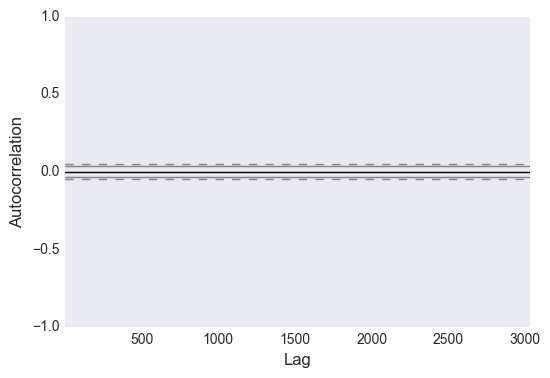

In [27]:
plt.style.use('ggplot')#'ggplot')
sns.set_style('darkgrid')
pd.plotting.autocorrelation_plot(series)

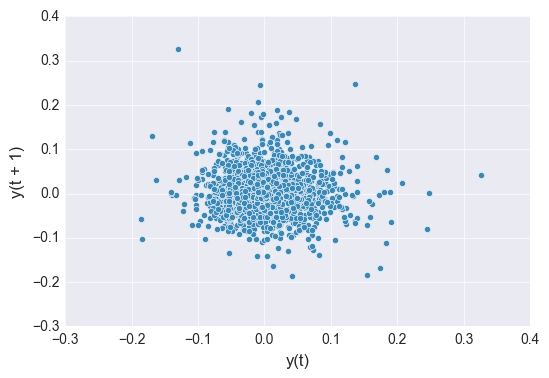

In [28]:
pd.plotting.lag_plot(series)

In [29]:
df3 = df2.copy()
df3['ctgo'] = df3['wtd_UX'] / df3['VIX'] - 1

# Contango exponential weighted moving averages
ctgo_ewm = 2
df3['ctgo_'+str(ctgo_ewm)+'dEMA'] = df3['ctgo'].ewm(min_periods=0, halflife=ctgo_ewm).mean()

# Contango MACD signal & MACD
MACD_params = (2, 10, 2)
df3['ctgo_MACD'] = (df3['ctgo'].ewm(min_periods=0, span=MACD_params[0]).mean()\
                  - df3['ctgo'].ewm(min_periods=0, span=MACD_params[1]).mean()).ewm(
    min_periods=0, span=MACD_params[2]).mean()

# SPY xd realized vol
RV_days = 2
df3['SPY_'+str(RV_days)+'dRV'] = np.sqrt(periodicity/RV_days*(np.log(1+df3['SPY'].pct_change())**2)\
                                   .rolling(RV_days).sum())*100

df3['SPY_'+str(RV_days)+'dRV'] = df3['SPY_'+str(RV_days)+'dRV'].fillna(method='bfill')

# Calculate TTO signal
TTO_ewm = 2
df3['TTO_'+str(TTO_ewm)+'dEMA'] = (df3['wtd_UX']\
                                 - df3['SPY_'+str(RV_days)+'dRV']).ewm(min_periods=0, halflife=TTO_ewm).mean()

df_vol_rets = df3.copy()
df_vol_rets.tail()

,SPY,VIX,VVIX,wtd_UX,XIV_ret,VXX_ret,ctgo,ctgo_2dEMA,ctgo_MACD,SPY_2dRV,TTO_2dEMA
2018-01-10,274.1200,9.82,93.70,11.398529,0.011719,-0.011035,0.160746,0.173136,-0.007543,3.064959,5.980091
2018-01-11,276.1200,9.88,92.24,11.445588,0.005757,-0.005771,0.158460,0.168837,-0.009492,8.339094,5.138434
2018-01-12,277.9200,10.16,92.22,11.610294,-0.001724,0.000387,0.142745,0.161195,-0.014235,10.944643,3.828386
2018-01-16,276.9700,11.66,106.49,12.075000,-0.048290,0.061509,0.035592,0.124407,-0.050225,8.244452,3.829019
2018-01-17,279.6101,11.29,98.25,11.856000,0.039779,-0.038397,0.050133,0.102652,-0.061394,11.321454,2.864090


### Relative Value Vol Weights

In [30]:
#------------------------------------------
# Vol dashboard
#------------------------------------------
t1 = time.time()
ctgo_thresh1 = -0.01
ctgo_thresh2 =  0.10
back_thresh1 =  0.12
back_thresh2 =  0.15

tto_XIV_thresh = 2
tto_VXX_thresh = -2

short_levg_min = 0.1 #.01
short_levg_max = 0.8 #1.5
long_levg_min = 1
long_levg_max = 2
scaling_max_back = 0.10

short_contract_min = 11
short_contract_max = 25

# Compute weights using TTO and contango/backwardation frameworks using boolean indexing
df_vol_rets['XIV_tto'] = df_vol_rets['TTO_'+str(TTO_ewm)+'dEMA'] > tto_XIV_thresh
df_vol_rets['VXX_tto'] = df_vol_rets['TTO_'+str(TTO_ewm)+'dEMA'] < tto_VXX_thresh

df_vol_rets['XIV_ctg'] = (df_vol_rets['ctgo_'+str(ctgo_ewm)+'dEMA'] > ctgo_thresh2) |\
                        ((df_vol_rets['ctgo_'+str(ctgo_ewm)+'dEMA'] > ctgo_thresh1) & (df_vol_rets['ctgo_MACD'] > 0))

df_vol_rets['VXX_ctg'] = (df_vol_rets['ctgo_'+str(ctgo_ewm)+'dEMA'] < -back_thresh2) |\
                        ((df_vol_rets['ctgo_'+str(ctgo_ewm)+'dEMA'] < -back_thresh1) & (df_vol_rets['ctgo_MACD'] < 0))

# Take average of TTO and contango methods
# Take average of XIV weights iff both VXX weights = 0
df_vol_rets['XIV_sign'] = (df_vol_rets.loc[:, ('VXX_tto', 'VXX_ctg')].sum(axis=1) == 0)\
                         * df_vol_rets.loc[:, ('XIV_tto', 'XIV_ctg')].sum(axis=1)/2
    
# Take average of VXX weights iff both XIV weights = 0
df_vol_rets['VXX_sign'] = (df_vol_rets.loc[:, ('XIV_tto', 'XIV_ctg')].sum(axis=1) == 0)\
                         * df_vol_rets.loc[:, ('VXX_tto', 'VXX_ctg')].sum(axis=1)/2

# Log scaling added; replaces lambda function in recycle bin at bottom of script
df_vol_rets['XIV_wt'] = df_vol_rets['XIV_sign']\
                      *((np.log(np.minimum(df_vol_rets['wtd_UX'], short_contract_max)) - np.log(short_contract_min))\
                        /(np.log(short_contract_max) - np.log(short_contract_min))\
                        *(short_levg_max - short_levg_min) + short_levg_min)

df_vol_rets['VXX_wt'] = df_vol_rets['VXX_sign']\
                      *(np.minimum(np.maximum(-df_vol_rets['ctgo_'+str(ctgo_ewm)+'dEMA'], 0), scaling_max_back)\
                        /scaling_max_back * (long_levg_max - long_levg_min) + long_levg_min)
    
print("Long XIV: ", "{0:,.1%}".format(1-(df_vol_rets['XIV_sign'] == 0).sum()/len(df_vol_rets)))
print("Long VXX: ", "{0:,.1%}".format(1-(df_vol_rets['VXX_sign'] == 0).sum()/len(df_vol_rets)))
print('{0:,.5f}'.format(time.time()-t1), 'seconds')

Long XIV:  88.6%
Long VXX:  5.3%
0.01501 seconds


### Vol Hedge Weights

In [31]:
#hedge_tks = ['SVXY', 'LQD', 'TLT', 'GLD', 'UGAZ']
#hedge_tks = ['SVXY', 'GLD', 'UGAZ', 'VMBS']
#hedge_tks = ['SVXY', 'TLT', 'GLD', 'UGAZ', 'VMBS']
#hedge_tks = ['SVXY', 'TLT', 'AMLP', 'LQD', 'GLD', 'UGAZ']
#hedge_tks = ['SVXY', 'RPG', 'VBK', 'TLT', 'UGAZ'] # IV solution with CAGR focus
#hedge_tks = ['RPG', 'IWM', 'SVXY', 'TLT', 'GLD', 'UGAZ']
hedge_tks = ['RPG', 'SVXY', 'TLT', 'GLD', 'UGAZ'] # IV solution
#hedge_tks = ['RPG', 'SVXY', 'TLT', 'AMLP', 'GLD', 'UGAZ'] # IV solution
#hedge_tks = ['RPG', 'IWM', 'SVXY', 'TLT', 'GLD', 'UGAZ'] # IV solution
#hedge_tks = ['RPG', 'TLT', 'SVXY', 'GLD', 'VUG'] # IV solution with 2x CAGR and no UGAZ
#hedge_tks = ['SVXY', 'VMBS', 'GLTR', 'LQD', 'VUG'] # ERC loop solution
#hedge_tks = ['RPG', 'VBK', 'SVXY', 'TLT', 'GLD', 'UGAZ']
#hedge_tks = ['SVXY', 'VMBS', 'UGAZ', 'SRLN', 'TLT'] # IV solution maximizing gain to pain
#hedge_tks = ['SVXY', 'VMBS', 'UGAZ', 'TLT', 'RPG'] # IV solution maximizing sortino
#hedge_tks = ['VUG', 'SVXY', 'TLT', 'VMBS', 'GLD'] # IV solution with no UGAZ

df_hedge_px = df[hedge_tks]
df_hedge_returns = df_hedge_px.pct_change()

if 'UGAZ' in df_hedge_returns.columns:
    df_hedge_returns['UGAZ'] *= -1               # Adjust for short sale
    df_hedge_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

hedge_returns_array = np.array(df_hedge_returns)

##########################################
###############   ERC    #################
##########################################
hedge_wts_arr = np.zeros(hedge_returns_array.shape) + 1/len(hedge_tks)

x0 = np.ones([len(hedge_tks), 1])/len(hedge_tks)
y0 = np.append(x0, newt_lambda0).reshape(len(hedge_tks)+1, 1)

for i in tqdm(range(corr_lookback, N)): 
    hedge_rets_array_corr = hedge_returns_array[i-corr_lookback+1:i+1, :]
    hedge_rets_array_cov  = hedge_returns_array[i-lookback+1:i+1, :]
    
    corr = np.corrcoef(hedge_rets_array_corr.T)
    #corr = stats.spearmanr(hedge_rets_array_corr)[0]
    cov_diag = np.diag(np.sqrt(np.var(hedge_rets_array_cov, axis=0)))
    omega = cov_diag @ corr @ cov_diag
    
    hedge_wts_arr[i] = getERCWeights(omega, y0, eps).T    
##########################################
##########################################

##########################################
##########   Inverse Beta    #############
##########################################
# hedge_returns_array = np.append(hedge_returns_array, np.zeros([len(hedge_returns_array), 1]), axis=1)

# hedge_wts_arr = np.zeros(hedge_returns_array[:, :-1].shape) + 1/len(hedge_tks)
# hedge_returns_array[1:lookback+1, -1] = (hedge_wts_arr[:lookback, :]*hedge_returns_array[1:lookback+1, :-1]).sum(axis=1)

# for i in tqdm(range(lookback, N)):
#     hedge_returns_array[i, -1] = (hedge_wts_arr[i-1]*hedge_returns_array[i, :-1]).sum()
#     #hedge_rets_arr_temp = numpy_ewm(hedge_returns_array[i-lookback+1:i+1], window=2, method='halflife')*syd_array*10**5
#     hedge_rets_arr_temp = hedge_returns_array[i-lookback+1:i+1]
#     betas = np.cov(hedge_rets_arr_temp.T)[-1, :-1]/np.var(hedge_rets_arr_temp[:, -1])
#     hedge_wts_arr[i] = (1/betas)/(1/betas).sum()
##########################################
##########################################

df_hedge_weights = pd.DataFrame(index=df_hedge_returns.index, columns=df_hedge_returns.columns, data=hedge_wts_arr)

if 'UGAZ' in df_hedge_returns.columns:
    df_hedge_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_hedge_weights['UGAZ'] *= -1
    df_hedge_weights['UGAZ'] = np.minimum(df_hedge_weights['UGAZ'], 0)
    
    # Set weights to max of zero
    df_hedge_weights.loc[:, df_hedge_weights.columns != 'UGAZ'] = np.maximum(
        df_hedge_weights.loc[:, df_hedge_weights.columns != 'UGAZ'], 0)

#df_hedge_weights = df_avg_weights.copy() # TO DELETE
df_hedge_weights = df_hedge_weights.drop(["SVXY"], axis=1)
hedge_tks.remove("SVXY")

df_hedge_weights.tail(1)

100%|████████████████████████████████████████████████████████████████████████████| 2528/2528 [00:02<00:00, 1121.55it/s]


,RPG,TLT,GLD,UGAZ
2018-01-17,0.30069,0.298683,0.315851,-0.029717


In [32]:
# Calculate weights for dynamic vol + risk parity (TLT + GLD) portfolio
vol_tks = ['XIV', 'VXX'] + hedge_tks
vol_wt_tks = [j+'_wt' for j in vol_tks]

df_vol_wts = pd.DataFrame(index=df_vol_rets.index, columns=tuple(vol_wt_tks))  
df_vol_wts.loc[:, ('XIV_wt', 'VXX_wt')] = df_vol_rets.loc[:, ('XIV_wt', 'VXX_wt')]

# Calculate weights for short vol hedges only if not already long VXX
for tk in hedge_tks:
    df_vol_wts[tk+'_wt'] = (leverage - df_vol_wts.loc[:, ('XIV_wt', 'VXX_wt')].sum(axis=1)) * df_hedge_weights[tk]\
                         / (df_hedge_weights.loc[:, tuple(hedge_tks)].sum(axis=1))

# Returns for dynamic vol + risk parity portfolio
df_dyn_vol_rets = pd.DataFrame(index=df_vol_rets.index, columns=tuple(vol_tks)) 
df_dyn_vol_rets['XIV'] = df_vol_rets['XIV_ret']
df_dyn_vol_rets['VXX'] = df_vol_rets['VXX_ret']

for tk in hedge_tks:
    df_dyn_vol_rets[tk] = df_hedge_returns[tk]

df_vol_wts.columns = df_dyn_vol_rets.columns

# Scale weights so absolute values including UGAZ equal to total leverage limit
df_vol_wts.loc[:, hedge_tks] = df_vol_wts.loc[:, hedge_tks].multiply(
    (df_vol_wts.loc[:, hedge_tks].sum(axis=1)/df_vol_wts.loc[:, hedge_tks].abs().sum(axis=1)), axis=0)

df_vol_wts.tail(1)

,XIV,VXX,RPG,TLT,GLD,UGAZ
2018-01-17,0.163896,0,0.584267,0.580368,0.613727,-0.057742


In [33]:
# Dynamic volatility portfolio returns -- no LQD, TLT, GLD, or UGAZ
df_vol_rets['Dynamic Vol'] = df_vol_rets['XIV_wt'].shift(1) * df_vol_rets['XIV_ret']\
                           + df_vol_rets['VXX_wt'].shift(1) * df_vol_rets['VXX_ret']\
                           - margin_rate*(np.maximum(df_vol_rets.loc[:, ('XIV_wt', 'VXX_wt')].sum(axis=1), 1)-1)/periodicity
    
df_vol_rets['RP_wt'] = 0
df_vol_rets['RP_wt'] = leverage - df_vol_rets.loc[:, ('XIV_wt', 'VXX_wt')].sum(axis=1)

# Returns Output

In [34]:
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
    df_returns['UGAZ'] *= -1               # Adjust for short sale

#df_returns['MV'] = MV_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['IV'] = IV_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['IB'] = IB_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['ERC'] = ERC_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['wt_avg'] = wt_avg_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['ERC_M'] = ERC_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['ERC+M'] = ERC_plus_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['MCRO'] = MCRO_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['HRP'] = HRP_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['DRP'] = DRP_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['DRP_M'] = DRP_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['DRP+M'] = DRP_plus_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity

df_returns.insert(loc=0, column='VTI', value=df['VTI'].pct_change())
df_returns = df_returns.iloc[corr_lookback:]
#df_returns = df_returns.iloc[21*24:]

In [35]:
#--------------------------------------------------------------
# Add vol returns - return period must be set to daily
#--------------------------------------------------------------
RP_dict = {"MV": MV_returns,
           "IV": IV_returns,
           "ERC": ERC_returns,
           "IB": IB_returns,
           "ERC_M": ERC_M_returns,
           "ERC+M": ERC_plus_M_returns,
           #"wt_avg": wt_avg_returns,
           #"MCRO": MCRO_returns,
           #"DRP": DRP_returns,
           #"DRP_M": DRP_M_returns,
           #"DRP+M": DRP_plus_M_returns,
           #"HRP": HRP_returns,
           }

active_RP = "ERC"

# Add weights to vol dataframe
df_vol_rets[str(active_RP)+"_wt"] = leverage - df_vol_rets["VXX_wt"]

# Add risk parity return streams to vol dataframe
df_vol_rets[active_RP] = RP_dict[active_RP]

# Returns from going long VXX selectively
df_returns['Long VXX'] = df_vol_rets['VXX_wt'].shift(1) * df_vol_rets['VXX_ret']\
                       - margin_rate*(np.maximum(df_vol_rets['VXX_wt'], 1) - 1)/periodicity
    
# Returns from relevant RP; selectively switch to full long vol position    
df_returns[str(active_RP)+"/VXX"] = df_vol_rets["VXX_wt"].shift(1) * df_vol_rets["VXX_ret"]\
                                  + df_vol_rets[str(active_RP)+"_wt"].shift(1) * df_vol_rets[active_RP]\
                                  - margin_rate*(np.maximum(leverage, 1)-1)/periodicity

df_returns['Dynamic Vol'] = df_vol_rets['Dynamic Vol']
#df_returns['VMBS'] = df['VMBS'].pct_change()
#df_returns['LQD'] = df['LQD'].pct_change()

# Dynamic vol portfolio from above: SVXY + TLT + GLD most of the time; occasionally switches to long VXX
df_returns["DynVol/"+str(active_RP)] = (df_vol_wts.shift(1)*df_dyn_vol_rets).sum(axis=1)\
                                     - margin_rate*(np.maximum(leverage, 1)-1)/periodicity

# Add appropriate labels to returns dataframe
ERCVXX_wt = 0.5
ERCVXX_label = to_percent(ERCVXX_wt)+" "+str(active_RP)+"/VXX, "+to_percent(1-ERCVXX_wt)+" Vol/"+str(active_RP)
df_returns[ERCVXX_label] = ERCVXX_wt*df_returns[str(active_RP)+"/VXX"]\
                         + (1-ERCVXX_wt)*df_returns["DynVol/"+str(active_RP)]

In [36]:
to_summary(df_returns)#.loc["Jan 2013":])#.iloc[:28]

,VTI,RPG,SVXY,TLT,GLD,UGAZ,ERC,ERC_M,ERC+M,Long VXX,ERC/VXX,Dynamic Vol,DynVol/ERC,"50% ERC/VXX, 50% Vol/ERC"
Summary Stats:,,,,,,,,,,,,,,
CAGR,9%,12%,33%,6%,4%,-81%,31%,5%,18%,35%,80%,106%,144%,111%
MOIC,2.46x,3.19x,17.8x,1.84x,1.50x,0.00x,14.7x,1.60x,5.28x,20.7x,360x,"1,430x","7,771x","1,759x"
Sharpe,0.45,0.56,0.53,0.41,0.21,-0.65,1.44,0.23,1.09,0.96,1.92,2.36,3.01,2.53
Sortino,0.71,0.88,0.78,0.69,0.35,-1.10,2.45,0.37,1.80,2.04,3.97,4.58,5.84,5.11
Information Ratio,nan,0.30,0.49,-0.10,-0.19,-0.72,0.90,-0.14,0.33,0.51,1.37,1.90,2.53,1.97
Skew,0.01,-0.02,-0.95,0.01,-0.04,0.30,-0.10,-0.16,-0.20,6.20,4.15,3.12,2.50,3.46
Max Drawdown,-53%,-51%,-83%,-27%,-46%,-100%,-30%,-36%,-17%,-30%,-30%,-30%,-30%,-30%
Ulcer Index,13.5,12.7,37.6,12.2,25.5,96.7,6.83,17.1,6.22,13.7,6.24,7.12,6.24,5.57
Ulcer Performance Index,0.69,0.97,0.88,0.51,0.16,-0.84,4.50,0.28,2.90,2.58,12.8,14.9,23.1,19.9


In [37]:
tax_rate = 0.35
RP_alloc = 0.5
vol_alloc = 1 - RP_alloc
RP_turn = 0.25
vol_turn = 0.5

rate1 = 0.37
rate2 = 0.64
nper = 3
pv = -142*10**3
pmt = (-200*(1-tax_rate) + 50)*10**3
when = 'end'

end_bal = np.fv(rate1*(1-tax_rate*RP_turn), nper, pmt*RP_alloc, pv*RP_alloc, when)\
        + np.fv(rate2*(1-tax_rate*vol_turn), nper, pmt*vol_alloc, pv*vol_alloc, when)
    
print("Ending balance after tax: ${0:,.0f}".format(end_bal))

end_next = end_bal*RP_alloc*rate1*(1-tax_rate*RP_turn) + end_bal*vol_alloc*rate2*(1-tax_rate*vol_turn)
print("Next year's income at same return: ${0:,.0f}".format(end_next))

Ending balance after tax: $782,809
Next year's income at same return: $338,809


0.11531 seconds


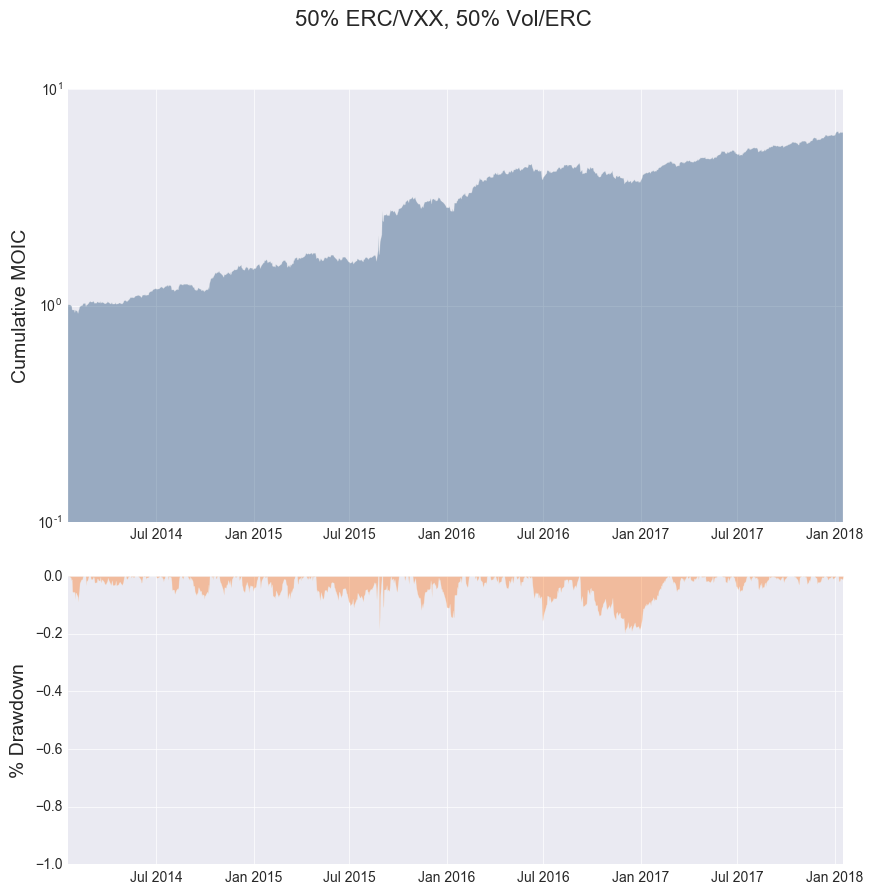

In [39]:
t1 = time.time()
plot_rets_dd(df_returns.iloc[-252*4:, -1], yscale='log', sizex=10, sizey=10)# #  {“linear”, “log”, “symlog”, “logit”})
print("{0:,.5f}".format(time.time()-t1), "seconds")

### Correlations

In [40]:
#df_corr = df[['RSP', 'HYG', 'SVXY', 'TLT', 'GLD', 'UGAZ']].pct_change()[1:]
corr_tks = hedge_tks+["SVXY"]
df_corr = df[corr_tks].pct_change()[1:]
#df_corr = df.copy()
df_corrM = np.cumprod(1+df_corr).resample('M').ffill().pct_change()[1:]
df_corrM.corr(method='spearman').applymap(to_decimal)#.sum(axis=0)#

,RPG,TLT,GLD,UGAZ,SVXY
RPG,1.00,-0.28,0.04,0.09,0.78
TLT,-0.28,1.00,0.18,-0.07,-0.36
GLD,0.04,0.18,1.00,0.10,-0.01
UGAZ,0.09,-0.07,0.10,1.00,0.11
SVXY,0.78,-0.36,-0.01,0.11,1.00


In [41]:
df_returnsM = np.cumprod(1+df_returns).resample('M').ffill().pct_change()[1:]
df_returnsM.corr(method='spearman').applymap(to_decimal)#.iloc[1:5, -5:]
#df_returnsM.corr(method='spearman').abs().iloc[1:5, -5:].sum(axis=0)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,ERC,ERC_M,ERC+M,Long VXX,ERC/VXX,Dynamic Vol,DynVol/ERC,"50% ERC/VXX, 50% Vol/ERC"
VTI,1.00,0.94,0.78,-0.34,0.01,0.05,0.44,0.09,0.33,-0.12,0.24,0.44,0.42,0.37
RPG,0.94,1.00,0.77,-0.29,0.06,0.04,0.48,0.11,0.37,-0.08,0.28,0.42,0.44,0.40
SVXY,0.78,0.77,1.00,-0.38,-0.02,0.07,0.39,0.10,0.31,-0.18,0.20,0.61,0.51,0.41
TLT,-0.34,-0.29,-0.38,1.00,0.21,-0.07,0.37,0.28,0.42,0.14,0.38,-0.22,0.06,0.19
GLD,0.01,0.06,-0.02,0.21,1.00,-0.01,0.51,0.25,0.49,0.05,0.46,0.05,0.30,0.40
UGAZ,0.05,0.04,0.07,-0.07,-0.01,1.00,-0.44,-0.01,-0.31,-0.12,-0.47,-0.02,-0.26,-0.36
ERC,0.44,0.48,0.39,0.37,0.51,-0.44,1.00,0.36,0.87,-0.06,0.78,0.23,0.59,0.70
ERC_M,0.09,0.11,0.10,0.28,0.25,-0.01,0.36,1.00,0.74,0.14,0.37,0.14,0.24,0.29
ERC+M,0.33,0.37,0.31,0.42,0.49,-0.31,0.87,0.74,1.00,-0.00,0.70,0.18,0.48,0.59
Long VXX,-0.12,-0.08,-0.18,0.14,0.05,-0.12,-0.06,0.14,-0.00,1.00,0.42,0.40,0.40,0.41


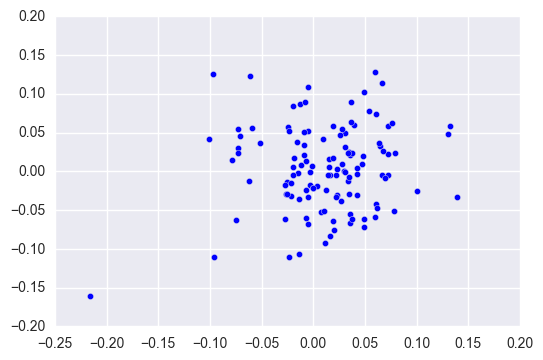

In [42]:
sns.set(style="darkgrid")
plt.scatter(df_returnsM["RPG"], df_returnsM["GLD"], s=20)

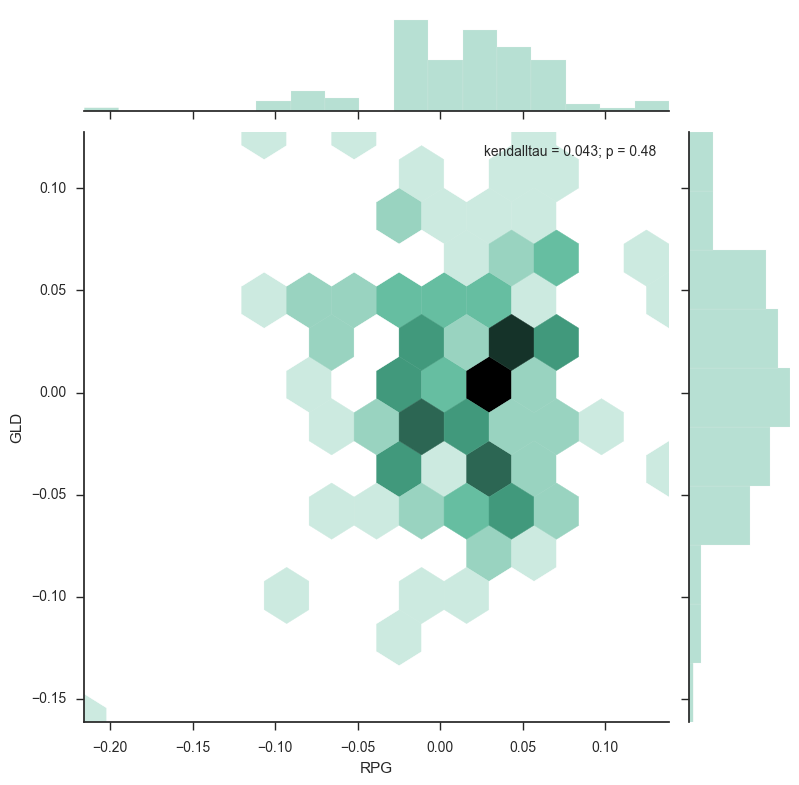

In [43]:
sns.set(style="ticks")
#sns.set(style="darkgrid")
sns.jointplot(df_returnsM["RPG"], df_returnsM["GLD"], kind="hex", stat_func=stats.kendalltau, color="#4CB391", size=8)

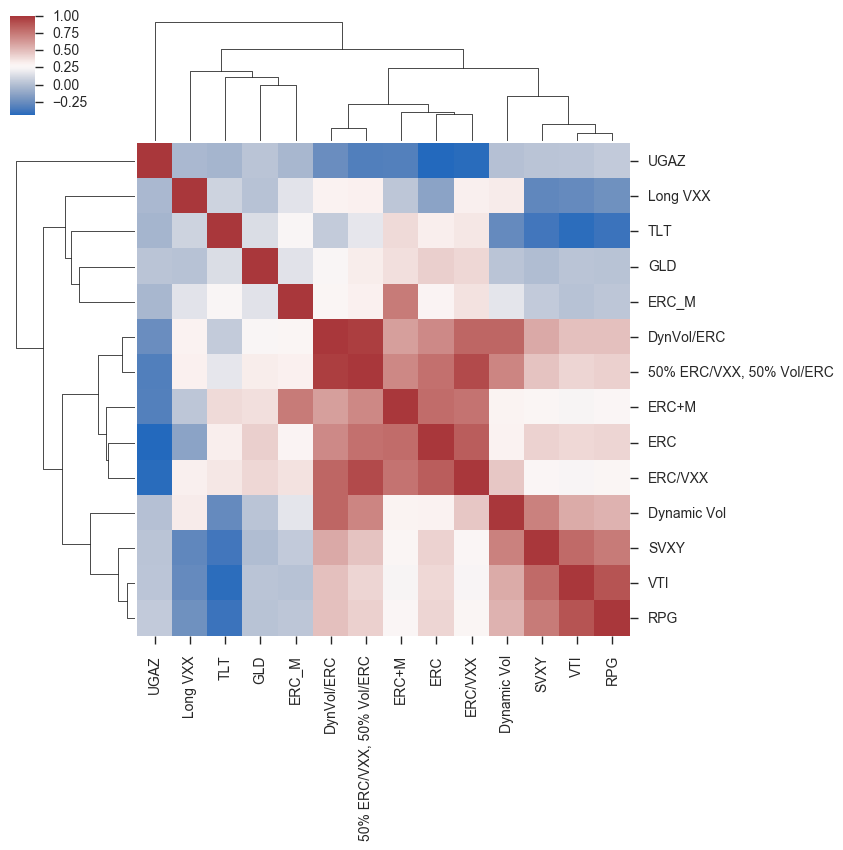

In [44]:
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(df_returns.corr(method='spearman'), cmap='vlag', figsize=(8,8))

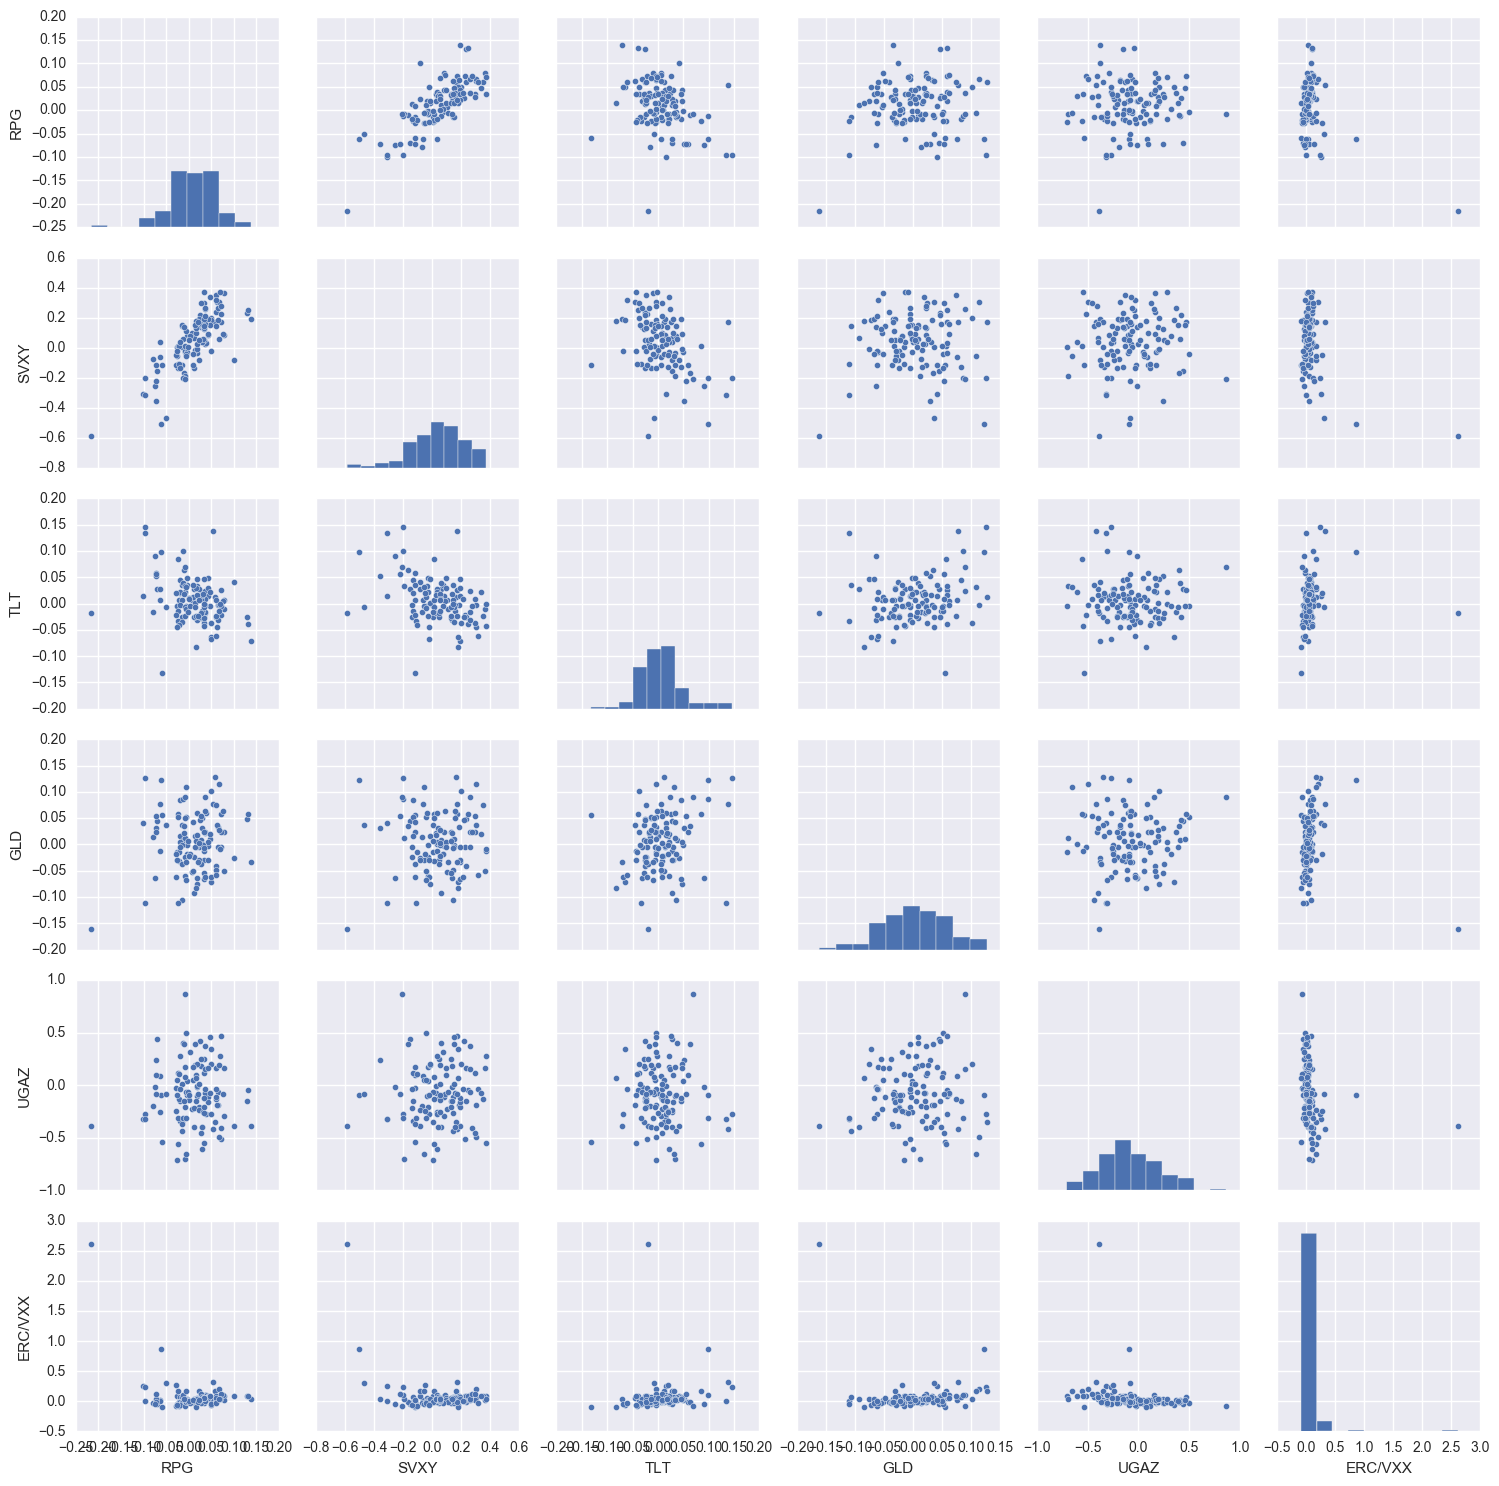

In [45]:
ERC_index = list(df_returns.columns).index(active_RP)
#pairplot_tks = list(df_returns.columns)[:ERC_index]
pairplot_tks = tickers.copy()
pairplot_tks = pairplot_tks + [str(active_RP)+"/VXX"] # , ERCVXX_label

#sns.set(style="ticks")
sns.set(style="darkgrid")

df_sns = df_returns.loc[:, tuple(pairplot_tks)] 
df_snsM = df_sns.resample('M').apply(lambda x: np.prod(1+x)-1)

sns.pairplot(df_snsM)

### Individual & Monthly Returns

In [46]:
m_start_str = "Dec 2015"
m_end_str   = "Jan 2017"
((1+df_returnsM.loc[m_start_str:m_end_str])-1).applymap(to_percent)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,ERC,ERC_M,ERC+M,Long VXX,ERC/VXX,Dynamic Vol,DynVol/ERC,"50% ERC/VXX, 50% Vol/ERC"
2015-12-31,-2%,-2%,-14%,-0%,-0%,-4%,-3%,-5%,-4%,-3%,-6%,-7%,-8%,-7%
2016-01-31,-6%,-7%,-22%,6%,5%,-8%,3%,1%,2%,11%,13%,8%,12%,12%
2016-02-29,-0%,-1%,-6%,3%,11%,-66%,17%,2%,9%,0%,17%,-4%,11%,14%
2016-03-31,7%,7%,37%,-0%,-1%,28%,4%,-4%,-0%,0%,4%,20%,21%,12%
2016-04-30,1%,-1%,1%,-1%,5%,8%,1%,-0%,0%,0%,1%,2%,2%,2%
2016-05-31,2%,4%,21%,1%,-6%,-4%,1%,-1%,0%,0%,1%,11%,10%,6%
2016-06-30,0%,-1%,-21%,7%,9%,87%,3%,3%,3%,-10%,-7%,-20%,-16%,-11%
2016-07-31,4%,5%,34%,2%,2%,-7%,9%,5%,7%,0%,9%,11%,17%,13%
2016-08-31,0%,-1%,11%,-1%,-3%,-7%,-2%,-2%,-2%,0%,-2%,4%,2%,0%
2016-09-30,0%,-0%,0%,-2%,1%,-7%,-1%,-4%,-2%,0%,-1%,2%,0%,-0%


In [47]:
# Cumulative monthly returns
(np.cumprod(1+df_returnsM.loc[m_start_str:m_end_str])-1).applymap(to_percent)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,ERC,ERC_M,ERC+M,Long VXX,ERC/VXX,Dynamic Vol,DynVol/ERC,"50% ERC/VXX, 50% Vol/ERC"
2015-12-31,-2%,-2%,-14%,-0%,-0%,-4%,-3%,-5%,-4%,-3%,-6%,-7%,-8%,-7%
2016-01-31,-8%,-9%,-33%,5%,5%,-12%,-1%,-4%,-2%,8%,6%,1%,2%,4%
2016-02-29,-8%,-10%,-37%,9%,16%,-70%,16%,-3%,7%,8%,24%,-3%,13%,19%
2016-03-31,-1%,-3%,-14%,8%,15%,-61%,20%,-7%,6%,8%,29%,16%,37%,33%
2016-04-30,-1%,-4%,-12%,8%,21%,-58%,21%,-7%,6%,8%,30%,19%,40%,35%
2016-05-31,1%,-1%,6%,9%,14%,-60%,23%,-8%,7%,8%,31%,32%,54%,43%
2016-06-30,1%,-1%,-16%,16%,24%,-25%,27%,-5%,10%,-3%,22%,6%,30%,26%
2016-07-31,6%,3%,12%,19%,27%,-30%,38%,-1%,17%,-3%,32%,18%,52%,42%
2016-08-31,6%,3%,25%,17%,22%,-35%,35%,-2%,16%,-3%,30%,23%,54%,42%
2016-09-30,6%,3%,25%,16%,23%,-39%,34%,-6%,13%,-3%,29%,25%,55%,42%


### Portfolio Weight Plots

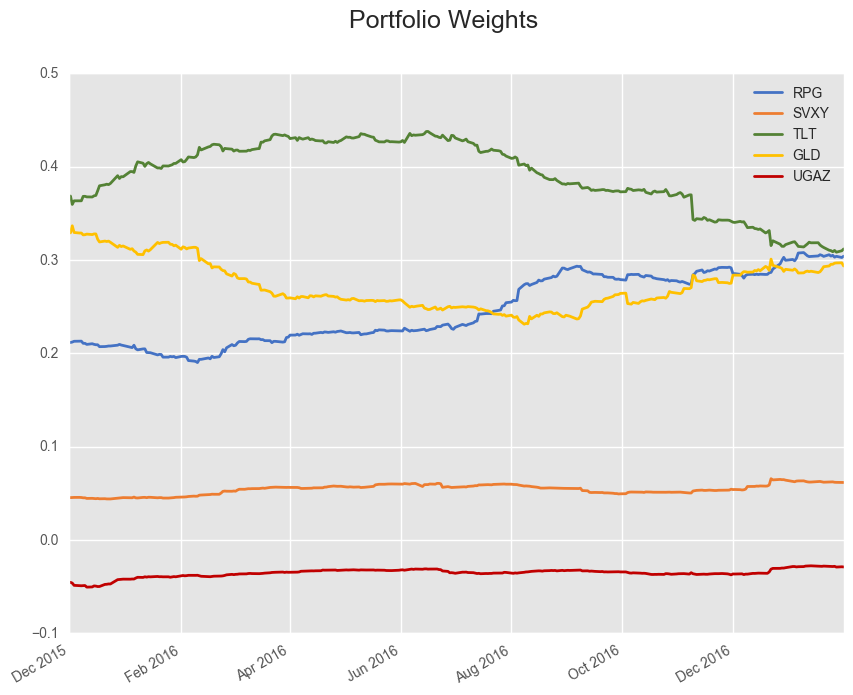

In [48]:
sns.set_style('darkgrid')
plt.style.use('ggplot')#'ggplot')
plt.figure()
plt.rcParams['figure.figsize'] = (10, 8)

colors = [(68/255, 114/255, 196/255),
          (237/255, 125/255, 49/255),
          (84/255, 130/255, 53/255),
          (255/255, 192/255, 0),
          (192/255, 0, 0),
          (165/255, 165/255, 165/255),
          (91/255, 155/255, 213/255),
          (68/255, 84/255, 106/255)]

df_ERC_weights.loc[m_start_str:m_end_str].plot(linewidth=2.0, color=colors)
#df_ERC_weights.loc["Aug 2008":"Aug 2010"].plot(linewidth=2.0, color=colors)
plt.legend(loc='best')
plt.suptitle('Portfolio Weights', fontsize=18)#, fontweight='bold')
axes = plt.gca()
#axes.set_ylim([-.8, 0.8])#-.5, .8])

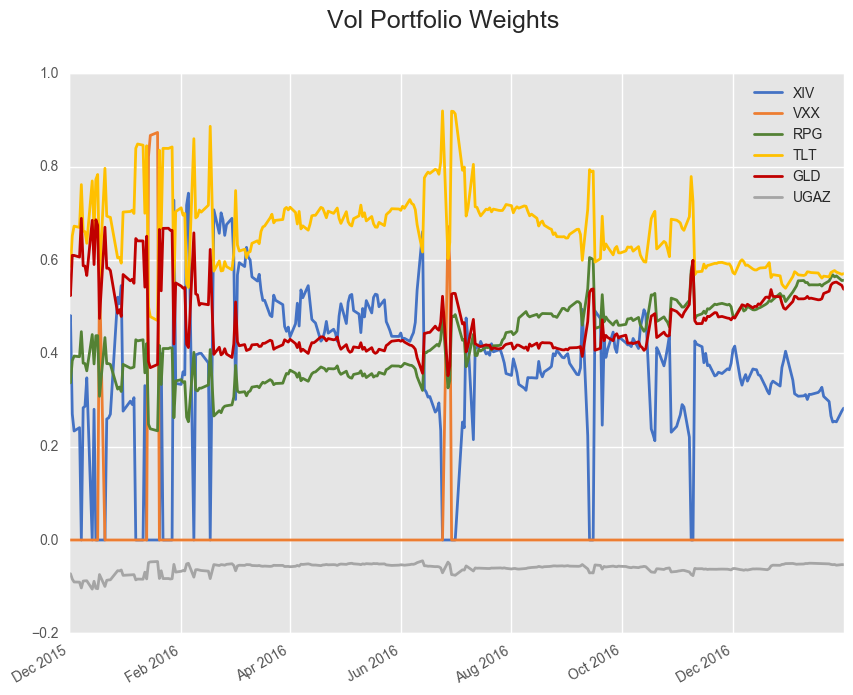

In [49]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 8)
df_vol_wts.loc[m_start_str:m_end_str].plot(linewidth=2, color=colors)
plt.legend(loc='best')
plt.suptitle('Vol Portfolio Weights', fontsize=18)#, fontweight='bold')
axes = plt.gca()
#axes.set_ylim([-.2, 1.25])#-.5, .8])

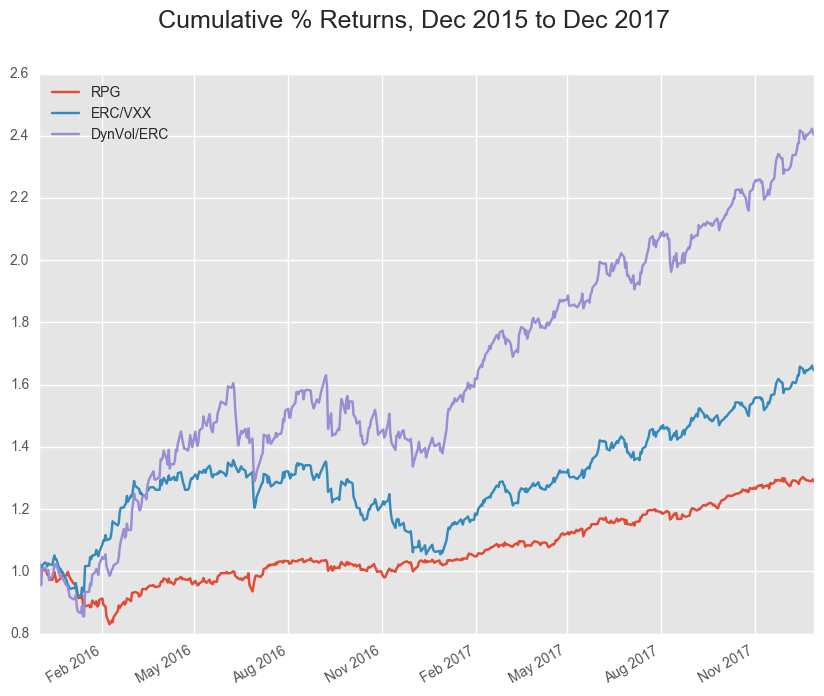

In [50]:
plt_start = 'Dec 2015'
plt_end   = 'Dec 2017'
plt.figure()
plt.rcParams['figure.figsize'] = (10, 8)
np.cumprod(1+df_returns.loc[plt_start:plt_end, ('RPG','ERC/VXX', 'DynVol/ERC')]).plot() #.applymap(to_percent)
plt.legend(loc='best')
#plt.yscale('log')
plt.suptitle('Cumulative % Returns, {0} to {1}'.format(plt_start, plt_end), fontsize=18)#, fontweight='bold')

# Security Selection

### Global Minimum Variance Framework

In [51]:
#----------------------------------
# Extract securities to target minimum portfolio variance
#----------------------------------
# Initial round
t1 = time.time()
df_returns2 = df.pct_change(1)[1:]
df_returns2['UGAZ'] *= -1               # Adjust for short sale
df_returns2['UGAZ'] -= .065/periodicity # Adjust for borrow cost

MV_tickers = ['SVXY']
df_returns3 = df_returns2.drop(MV_tickers, axis=1)
iter_limit = 5
sel_lookback = 252*20

iters = len(MV_tickers)
while iters < iter_limit:
    min_port_var = 10**6
    min_port_var_tick = ''

    for tick in df_returns3.columns:
        MV_tickers.append(tick)
        n_MV_tickers = len(MV_tickers)
        x0 = np.ones([n_MV_tickers, 1])/n_MV_tickers
        y0 = np.append(x0, newt_lambda0).reshape(-1, 1)
        
        returns_array = np.array(df_returns2[MV_tickers][-sel_lookback:])*1000
        omega = np.cov(returns_array.T)
        w = min_var(returns_array, MV_lambda)
        port_var = (w.T @ omega @ w)[0, 0]
        if port_var < min_port_var:
            min_port_var = port_var
            min_port_var_tick = tick

        MV_tickers.remove(tick)

    MV_tickers.append(min_port_var_tick)
    df_returns3 = df_returns3.drop(min_port_var_tick, axis=1)
    iters += 1
    
print('{0:,.3f}'.format(time.time()-t1), 'seconds')
print("Tickers:", MV_tickers)

0.149 seconds
Tickers: ['SVXY', 'VMBS', 'SRLN', 'CWB', 'EMB']


In [ ]:
['RPG', 'SVXY', 'UGAZ', 'VMBS']

### Inverse Vol Weights; Max CAGR & Ulcer Performance Index (Fast)

In [ ]:
df_months2 = df_returns2.resample('M').apply(lambda x: np.prod(1+x)-1)

In [ ]:
sns.clustermap(df_months2.corr(method='spearman'), cmap='vlag', figsize=(9, 9))

In [ ]:
'UGAZ' in df.columns

In [ ]:
df9 = df.drop('UGAZ', axis=1)

In [52]:
#----------------------------------
# Extract securities to target maximum ulcer performance index + CAGR
#----------------------------------
# Initial round
t1 = time.time()
df_returns2 = df.pct_change(1)[1:]

IV_tickers = ['SVXY']
df_returns3 = df_returns2.drop(IV_tickers, axis=1)
iter_limit = 5
tot_lookback = 252*20
vol_lookback = 252

iters = len(IV_tickers)
while iters < iter_limit:
    min_cross_ent = -10**4
    best_tick = ''

    for tick in tqdm(df_returns3.columns):
        IV_tickers.append(tick)
        df_returns4 = df_returns2[IV_tickers][-tot_lookback:]
        
        if 'UGAZ' in IV_tickers:
            df_returns4['UGAZ'] *= -1               # Adjust for short sale
            df_returns4['UGAZ'] -= .065/periodicity # Adjust for borrow cost
        
        df_RV_sel = np.sqrt(periodicity/vol_lookback*(np.log(1+df_returns4)**2).rolling(vol_lookback).sum())*100
        arr_IV_sel = np.array(1/df_RV_sel)
        IV_wt_arr_sel = arr_IV_sel/arr_IV_sel.sum(axis=1).reshape(-1, 1)
        df_IV_sel_weights = pd.DataFrame(index=df_RV_sel.index, columns=df_RV_sel.columns, data=IV_wt_arr_sel)
            
        if 'UGAZ' in IV_tickers:
            df_returns4['UGAZ'] *= -1               # Re-adjust for short sale
            df_IV_sel_weights['UGAZ'] *= -1
            
        IV_returns_sel = (df_IV_sel_weights.shift(1)*df_returns4).sum(axis=1)
        MOIC = np.prod(1+IV_returns_sel)
        CAGR = MOIC**(periodicity/len(IV_returns_sel))-1
        ulcer_index = np.sqrt(np.sum((np.cumprod(1+IV_returns_sel)\
                                      /np.maximum.accumulate(np.cumprod(1+IV_returns_sel))-1)**2)\
                              /len(IV_returns_sel))*100
        
        gain_to_pain = -np.sum(IV_returns_sel)/np.sum(np.clip(IV_returns_sel, a_max=0, a_min=None))
        sortino = CAGR/(np.std(np.clip(IV_returns_sel, a_max=0, a_min=None))*np.sqrt(periodicity))
        
        ulcer_perf = CAGR/ulcer_index*100
        cross_ent = 1*np.log(CAGR) + 1*np.log(ulcer_perf)# + 0*np.log(gain_to_pain) + 1*np.log(sortino)
        if cross_ent > min_cross_ent:
            min_cross_ent = cross_ent
            best_tick = tick
        
        IV_tickers.remove(tick)
        
    IV_tickers.append(best_tick)
    df_returns3 = df_returns3.drop(best_tick, axis=1)
    iters += 1

print('{0:,.3f}'.format(time.time()-t1), 'seconds')
print("Tickers:", IV_tickers)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 11.90it/s]


4.692 seconds
Tickers: ['SVXY', 'UGAZ', 'TLT', 'RPG', 'GLD']


### ERC Weights; Max CAGR & Ulcer Performance Index (Slow)

In [ ]:
#----------------------------------
# Extract securities to target maximum ulcer performance index
#----------------------------------
# Initial round
df_returns2 = df.pct_change(1)

ERC_tickers = ['SVXY']
tot_lookback = 252*20+1
vol_lookback = 252
df_returns3 = df_returns2.drop(tickers, axis=1)
df_returns3 = df_returns3.iloc[-tot_lookback:, :]
N = len(df_returns3)
iter_limit = 5
syd_array_sel = np.arange(1, vol_lookback+1)/np.arange(1, vol_lookback+1).sum()
syd_array_sel = syd_array_sel.reshape(-1, 1)

iters = len(ERC_tickers)
while iters < iter_limit:
    min_cross_ent = -10**4
    max_tick = ''

    t1 = time.time()
    for k, tick in enumerate(df_returns3.columns):
        print(k+1, '/', len(df_returns3.columns))
        ERC_tickers.append(tick)
        n_ERC_tickers = len(ERC_tickers)
        x0 = np.ones([n_ERC_tickers, 1])/n_ERC_tickers
        y0 = np.append(x0, newt_lambda0).reshape(n_ERC_tickers+1, 1)
        df_returns4 = df_returns2.loc[:, ERC_tickers]
        
        if 'UGAZ' in ERC_tickers:
            df_returns4.loc[:, 'UGAZ'] *= -1               # Adjust for short sale
            df_returns4.loc[:, 'UGAZ'] -= .065/periodicity # Adjust for borrow cost
        
        # Calculate ERC risk parity weights
        ERC_returns_array = np.array(df_returns4)
        ERC_wts_arr_sel = np.zeros(ERC_returns_array.shape) + 1/n_ERC_tickers

        for i in tqdm(range(vol_lookback, N)): 
            #returns_array_temp = numpy_ewm(returns_array[i-vol_lookback+1:i+1, :], window=2, method='halflife')*syd_array_sel*10**5
            returns_array_temp = ERC_returns_array[i-vol_lookback+1:i+1, :]*syd_array_sel*10**5
            omega = np.cov(returns_array_temp.T)
            ERC_wts_arr_sel[i] = getERCWeights(omega, y0, eps).T

        df_ERC_weights_sel = pd.DataFrame(index=df_returns4.index, columns=df_returns4.columns, data=ERC_wts_arr_sel)
            
        if 'UGAZ' in ERC_tickers:
            df_returns4.loc[:, 'UGAZ'] *= -1               # Re-adjust for short sale
            df_ERC_weights_sel.loc[:, 'UGAZ'] *= -1
            
        ERC_returns_sel = (df_ERC_weights_sel.shift(1)*df_returns4).sum(axis=1)
        MOIC = np.prod(1+ERC_returns_sel)
        CAGR = MOIC**(periodicity/len(ERC_returns_sel))-1
        ulcer_index = np.sqrt(np.sum((np.cumprod(1+ERC_returns_sel)\
                                      /np.maximum.accumulate(np.cumprod(1+ERC_returns_sel))-1)**2)\
                              /len(ERC_returns_sel))*100
        
        ulcer_perf = CAGR/ulcer_index*100
        cross_ent = np.log(CAGR) + np.log(ulcer_perf)
        if cross_ent > min_cross_ent: 
            min_cross_ent = cross_ent
            max_tick = tick
        
        ERC_tickers.remove(tick)
        
    ERC_tickers.append(max_tick)
    df_returns3 = df_returns3.drop(max_tick, axis=1)
    print(max_tick)
    print('{0:,.0f}'.format(time.time()-t1), 'seconds')
    iters += 1

print("Tickers:", ERC_tickers)

In [ ]:
['SVXY', 'VMBS', 'GLTR', 'LQD', 'VUG']

# Miscellaneous

In [ ]:
def swim_pace_calc(laps, mins, secs, yard_pace):
    yards_swam = laps*50
    total_sec = mins*60 + secs
    sec_per_yard = total_sec/yards_swam
    sec_per_x = sec_per_yard*yard_pace
    total_minutes = np.floor(sec_per_x/60)
    remain_secs = np.floor(((sec_per_x/60)-total_minutes)*60)
    print('Pace for %.0f yards: %.0f:%.0f' % (yard_pace, total_minutes, remain_secs))

In [ ]:
swim_pace_calc(36, 30, 0, 500)

In [ ]:
def row_to_mile(meters_row, mins_row, secs_row):
    miles_rowed = meters_row/1609.344
    total_sec = mins_row*60 + secs_row
    sec_per_mile = total_sec/miles_rowed
    total_minutes = np.floor(sec_per_mile/60)
    remain_secs = np.floor((sec_per_mile/60 - total_minutes)*60)
    print('Pace for 1 mile: %.0f:%.0f' % (total_minutes, remain_secs))

In [ ]:
row_to_mile(5000, 20, 37)

In [ ]:
# truth tables
truth = pd.DataFrame(columns=('X', 'Y'))

truth['X'] = [0, 0, 1, 1]
truth['Y'] = [0, 1, 0, 1]

truth['AND'] = truth['X'] * truth['Y']
truth['NAND'] = 1 - truth['X'] * truth['Y']
truth['OR'] = truth['X'] + truth['Y'] - truth['X'] * truth['Y']
truth['NOR'] = (1-truth['X']) * (1-truth['Y'])
truth['XOR'] = truth['X'] * (1-truth['Y']) + truth['Y'] * (1-truth['X'])
truth['XNOR'] = truth['X'] * truth['Y'] + (1-truth['X']) * (1-truth['Y'])
truth

In [ ]:
tbool = pd.DataFrame(columns=('A', 'B'))

tbool['A'] = [0, 0, 1, 1]
tbool['B'] = [0, 1, 0, 1]

tbool['AND'] = tbool['A'] & tbool['B']
tbool['NAND'] = 1 - (tbool['A'] & tbool['B'])
tbool['OR'] = tbool['A'] | tbool['B']
tbool['NOR'] = 1 - (tbool['A'] | tbool['B'])
tbool['XOR'] = tbool['A'] ^ tbool['B']
tbool['XNOR'] = 1 - (tbool['A'] ^ tbool['B'])
tbool

In [ ]:
truth.applymap(lambda x: x*2)